### Convolutional Neural Network (CNN) for Processing and Classifying CIFAR-10 Images from Scratch

### Part 1: Initial Data Processing

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

np.random.seed(3)

Load up initial data from CIFAR-10:
* 10 classes of images (airplane, automobile, bird...)
* 6000 images per class (5000 train, 1000 test)

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

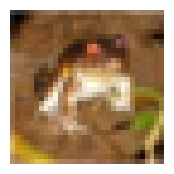

In [21]:
def load_batch_from_file(file_path):
    # load data from a CIFAR-10 batch file using pickle
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = np.array(batch[b'data'])
    labels = np.array(batch[b'labels'])
    return data, labels


# reshape data into 3 channels of 32x32 images
data, labels = load_batch_from_file('cifar-10-batches-py/data_batch_1')
data_separated = data[0].reshape(3, 32, 32)

img = data_separated.transpose(1, 2, 0)  # (H, W, C)

# display first image for test
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis("off")


Process all training and test batches from cifar-10-batches-py folder

In [22]:
def load_batches():
    X_list, Y_list = [], []

    # load training batches 1 to 5
    for i in range(1, 6):
        path = f'cifar-10-batches-py/data_batch_{i}'
        data, labels = load_batch_from_file(path)

        X_list.append(data)
        Y_list.append(labels)

    # concatenate all training batches
    X_train = np.concatenate(X_list)
    Y_train = np.concatenate(Y_list)

    # test batch
    X_test, Y_test = load_batch_from_file('cifar-10-batches-py/test_batch')

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = load_batches()

# shapes
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (50000, 3072)
Y_train: (50000,)
X_test: (10000, 3072)
Y_test: (10000,)


Reshape datasets into (3, 32, 32) and normalize

In [23]:
# reshape to (N, 3, 32, 32)
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

print("X_train reshaped:", X_train.shape)
print("X_test reshaped:", X_test.shape)

# normalize pixel values to [0, 1] and convert to float32 for precision
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train reshaped: (50000, 3, 32, 32)
X_test reshaped: (10000, 3, 32, 32)


Utility functions for later. Split train into train + validation and iterate through batches during training

In [24]:
def train_val_split(X, Y, ratio=0.1):
    """
    Split the training data into new training and validation sets.
    """
    N = len(X)
    random_indices = np.random.permutation(N)
    val_size = int(N * ratio)

    # calculate validation and new training indices
    val_i = random_indices[:val_size]
    train_i = random_indices[val_size:]

    X_val, Y_val = X[val_i], Y[val_i]
    X_train_new, Y_train_new = X[train_i], Y[train_i]

    return X_train_new, Y_train_new, X_val, Y_val


def batch_generator(X, Y, batch_size=64, random=True):
    """
    Generate batches of data from X and Y with specified batch size.
    """
    N = len(X)
    indices = np.arange(N)

    # shuffle indices
    if random:
        indices = np.random.permutation(N)

    for start in range(0, N, batch_size):
        # determine the end index of the batch, if > N, set to N
        end = min(start + batch_size, N)
        batch_indices = indices[start:end]

        # process batch one by one
        yield X[batch_indices], Y[batch_indices]


# split training data into new training and validation sets
X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, ratio=0.1)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)


X_train: (45000, 3, 32, 32)
Y_train: (45000,)
X_val: (5000, 3, 32, 32)
Y_val: (5000,)


### Part 2: The Convolution Layer and Feature Extraction

Work in Progress

In [25]:
testImg = data_separated.astype(np.float32) / 255.0

def convolve(X, filters, padding=0, stride=1):
    """
    Perform convolution on input image X with specified filters and kernel size

    X: input image of shape (C, H, W)
    filters: shape (num_filters, k_depth, kH, kW)
    """
    # dimensions
    num_filters = filters.shape[0]
    k_depth = filters.shape[1]
    kH = filters.shape[2]
    kW = filters.shape[3]
    C, H, W = X.shape
    kernels = filters

    if padding > 0:
        X = np.pad(X, ((0,0), (padding, padding), (padding, padding)), mode='constant')

    outH = (H - kH + 2 * padding) // stride + 1
    outW = (W - kW + 2 * padding) // stride + 1
    output = np.zeros((num_filters, outH, outW))

    # print(kernels.shape)

    for d in range(num_filters):
        kernel = kernels[d] # select the d-th kernel

        for i in range(outH):
            for j in range(outW):
                h1 = i * stride
                h2 = h1 + kH
                w1 = j * stride
                w2 = w1 + kW

                # perform convolution of the kernel and image region
                r = X[:, h1:h2, w1:w2]
                output[d, i, j] = np.sum(r * kernel)

    return output


In [ ]:
# convolve w/ imc2col
from numpy.lib.stride_tricks import as_strided, sliding_window_view

def convolve_im2col(X, filters, padding=0, stride=1):
    """
    Perform convolution on input images X with specified filters and kernel size

    X: input image of shape (N, C, H, W)
    filters: shape (num_filters, k_depth, kH, kW)
    """ 
    num_img, C, H, W = X.shape
    num_filters, _, kH, kW = filters.shape

    outH = (H - kH + 2 * padding) // stride + 1
    outW = (W - kW + 2 * padding) // stride + 1

    # image to column
    X_padded = np.pad(X, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode="constant")

    windows = sliding_window_view(X_padded, (kH, kW), (2, 3))

    windows_T = windows.transpose(1, 4, 5, 0, 2, 3)

    X_col = windows_T.reshape((C * kH * kW, -1))
    filters_flattened = filters.reshape(num_filters, -1)

    conv_prod = np.matmul(filters_flattened, X_col)
    conv_out = conv_prod.reshape((num_filters, num_img, outH, outW)).transpose((1, 0, 2, 3))

    return conv_out

### RELU Activation and Pooling

In [26]:
def activation_ReLU(X):
    return np.maximum(0, X)


def max_pool(X, pool_size=(2, 2), stride=2, padding=0):
    """
    Perform max pooling on input feature map X with specified pool size and stride.

    X: input feature map of shape (D, H, W)
    """
    p_height, p_width = pool_size
    num_filters, H, W = X.shape

    outH = (H - p_height + 2 * padding) // stride + 1
    outW = (W - p_width + 2 * padding) // stride + 1
    output = np.zeros((num_filters, outH, outW))

    for d in range(num_filters):
        for i in range(outH):
            for j in range(outW):
                h1 = i * stride
                h2 = h1 + p_height
                w1 = j * stride
                w2 = w1 + p_width
                  
                region = X[d, h1:h2, w1:w2]
                output[d, i, j] = np.max(region)

    return output


def perform_convolutions(X, kernels):
    """
    Performs n amount of convolutions on image X, returning the final feature map
    """
    cache = []
    current = X # keeping track of current conv

    for filters in kernels:
        conv = convolve(current, filters)
        conv_activated = activation_ReLU(conv)
        pool_out = max_pool(conv_activated)

        # 4. SAVE EVERYTHING!
        # We store a tuple: (Input to this layer, Conv Output, ReLU Output, Pool Output)
        layer_memory = {
            'input': current,         
            'conv_out': conv,         
            'relu_out': conv_activated,
            'pool_out': pool_out       
        }
        cache.append(layer_memory)

        current = pool_out

    return current, cache



### Rewritng the Pipeline for Vectorization

In [ ]:
def max_pool_window(X, pool_size=(2, 2), stride=2):
    """
    Perform max pooling on input feature map X with specified pool size and stride.

    X: input feature map of shape (N, C, H, W)
    """
    pH, pW = pool_size

    windows = sliding_window_view(X, (pH, pW), (2, 3))
    windows = windows[:, :, ::stride, ::stride, :, :]
    
    max_out = windows.max(axis=(4, 5))

    return max_out


def perform_convolutions_col(X, kernels):
    """
    Performs n amount of convolutions on images X, returning the final feature map
    """
    layers = []
    current = X # keeping track of current conv

    for filters in kernels:
        conv = convolve_im2col(current, filters, padding=1, stride=1)
        conv_activated = activation_ReLU(conv)
        pool_out = max_pool_window(conv_activated)

        layer_data = {
            'input': current,         
            'conv_out': conv,         
            'relu_out': conv_activated,
            'pool_out': pool_out       
        }
        layers.append(layer_data)

        current = pool_out

    return current, layers


### Part 3: The Dense Layer and Softmax

In [ ]:
def dense_layer(conv_out, w, b):
    """
    Takes a flattened conv_out and returns a list of 10 values
    """
    dense = conv_out.dot(w) + b
    return dense


def soft_max(dense_out):
    e_x = np.exp(dense_out - np.max(dense_out))
    return e_x  / np.sum(e_x)


def select_max_prob(probs):
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    p_indices = np.argmax(probs, axis=1)
    
    predictions = [classes[idx] for idx in p_indices]
    
    batch_indices = np.arange(len(probs))
    confidences = probs[batch_indices, p_indices] * 100

    return predictions, confidences, p_indices


In [ ]:
def soft_max_batch(dense_out):
    e_x = np.exp(dense_out - np.max(dense_out, axis=1, keepdims=True))
    return e_x  / np.sum(e_x, axis=1, keepdims=True)

### Full Forward Pass

In [ ]:
def forward_pass(X, w, b, kernel_weights):
    """
    Performs the entire forward pass operation on image X
    """
    conv_3d, layer_data = perform_convolutions(X, kernel_weights)
    conv_flattened = conv_3d.reshape(conv_3d.shape[0], -1)
    dense_out = dense_layer(conv_flattened, w, b)

    probabilities = soft_max(dense_out)
    # print(f"Prediction: {prediction} with a confidence of {conf:.2f}%")
    
    return probabilities, conv_flattened, layer_data


In [29]:
def check_pred(X, Y, w, b, kW):
    """
    Checks if prediction matches the given input image
    """
    probs, _, _ = forward_pass(X, w, b, kW)
    prediction, conf, pred_index = select_max_prob(probs)

    return pred_index == Y

Initialize kernel and dense weights. Then, perform the forward pass

In [ ]:
# # initializing kernel and dense layer weights
# # THIS IS THE STATE 
# kW1 = np.random.randn(16, 3, 3, 3) * np.sqrt(2 / 27)
# kW2 = np.random.randn(32, 16, 3, 3) * np.sqrt(2 / 144)
# kW3 = np.random.randn(64, 32, 3, 3) * np.sqrt(2 / 288)
# kW = [kW1, kW2, kW3]

# global_weights = np.random.randn(1024, 10) * np.sqrt(2 / 1024)
# global_biases = np.zeros(10)

In [48]:
# load up existing weights
with open("cifar_long_epoch_16.pkl", "rb") as f:
    loaded_data= pickle.load(f)

kW = loaded_data["kernels"]
global_weights = loaded_data["w"]
global_biases = loaded_data["b"]
# loss_collection = loaded_data["loss_collection"]

print("Weights loaded successfully!")


Weights loaded successfully!


In [32]:
forward_pass(testImg, global_weights, global_biases, kW)

(array([0.00985012, 0.00099161, 0.04604636, 0.08689232, 0.21403652,
        0.1575691 , 0.35213448, 0.1305276 , 0.00114204, 0.00080986]),
 array([0.16321444, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.9625959 , 2.23661064,
        3.24855822, 3.47375456, 0.43900326, 1.131845  , 1.78007243,
        1.57552201, 0.08987642, 0.24396929, 0.        , 0.        ,
        0.62432373, 0.18025475, 1.00990088, 1.65769153, 0.        ,
        1.57288289, 1.27396941, 1.26839024, 1.85554886, 1.77109015,
        2.66015465, 2.09474296, 0.        , 0.68663547, 3.20109954,
        2.15497577, 0.        , 0.        , 1.16143551, 1.55202349,
        0.        , 1.03638605, 1.28506342, 1.4635757 , 0.58644154,
        0.55747275, 1.77861837, 1.54284547, 0.        , 0.        ,
        0.39328371, 1.15424704, 0.        , 1.73033609, 0.8038051 ,
        0.64851943, 0.        , 0.02175409, 0.7990305 , 1.16497984,
        0.69725685, 0.71956435, 1.8314759 , 2.

### Part 4: Stochastic Gradient Descent and Back Propagation

In [33]:
def one_hot(Y):
    one_hot_vector = np.zeros(10)
    one_hot_vector[Y] = 1.0
    
    return one_hot_vector


def stoch_gradient_descent(X, Y, w, b, kernels, alpha=0.01):
    # probs [] and flattened feature map  is returned
    probs, conv_out, cache = forward_pass(X, w, b, kernels) 

    loss = -np.log(probs[Y] + 1e-9) # small offset to avoid 0 log

    new_w, new_b, gradients = backward_pass(
        probs, Y, w, b, conv_out, cache, kernels, alpha
    )
    
    # Re-pack the kernels
    new_kernels = []
    for i in range(len(gradients)):
        new_k = kernels[i] - (alpha * gradients[i])

        new_kernels.append(new_k)

    return new_w, new_b, loss, new_kernels


def calc_input_gradients(d_conv_out, kernel):
    """
    Calculates the error for the preceding convolution layer
    """
    # flip and tranpose so filters and channels are swapped
    k = np.flip(kernel, axis=(2, 3)).transpose(1, 0, 2, 3)
    padding = kernel.shape[2] - 1

    d_input = convolve(d_conv_out, k, padding=padding)

    return d_input


def backward_pass(probs, Y, w, b, conv_out, cache, kernels, alpha=0.01):
    """
    Handles the backward pass from Loss -> Dense -> Conv Output.
    """
    trueY = one_hot(Y)
    dLZ = (probs - trueY)
    
    # derivative of loss w.r.t W
    dzW = conv_out
    
    # d of loss w.r.t weights and biases
    dLW = np.outer(dzW, dLZ)
    dLB = dLZ
    
    d_flattened = w.dot(dLZ)
    
    # update Dense Weights & Biases
    new_w = w - (alpha * dLW)
    new_b = b - (alpha * dLB)
    
    layer3_data = cache[-1] 
    p3 = layer3_data['pool_out']   

    # Reshape flat error back to 3D
    current_error = d_flattened.reshape(p3.shape)

    gradients = []
    for i in reversed(range(len(kernels))):
        layer_data = cache[i]

        a_i = layer_data['relu_out'] 
        c_i = layer_data['conv_out']  
        layer_input = layer_data['input']   

        d_relu_out = reverse_max_pool(current_error, a_i)
        d_conv_out = reverse_ReLU(d_relu_out, c_i) # the error map
        d_kWi = backward_convolution(d_conv_out, layer_input)

        gradients.insert(0, d_kWi)

        d_input = calc_input_gradients(d_conv_out, kernels[i])

        current_error = d_input


    return new_w, new_b, gradients


# work in progress
def backward_convolution(d_conv_out, X_input, kernel_size=(3,3)):
    """
    Calculates the gradient for the kernels (weights).
    
    d_conv_out: Error map from the next layer (Num_Filters, Out_H, Out_W)
    X_input:    Input that went into the layer (Channels, In_H, In_W)
    """
    num_filters, d_h, d_w = d_conv_out.shape
    channels, img_h, img_w = X_input.shape
    k_h, k_w = kernel_size
    
    # Initialize gradient block: (Filters, Channels, 3, 3)
    d_kernels = np.zeros((num_filters, channels, k_h, k_w))
    
    for f in range(num_filters):
        for c in range(channels):
            for i in range(k_h):
                for j in range(k_w):
                    # We slide the input "window" over the error map
                    # This tells us how much the pixel at (i,j) contributed to the total error
                    input_slice = X_input[c, i:i+d_h, j:j+d_w]
                    
                    d_kernels[f, c, i, j] = np.sum(input_slice * d_conv_out[f])
                    
    return d_kernels


def reverse_ReLU(d_out, X_input):
    d_input = d_out.copy() 
    d_input[X_input <= 0] = 0

    return d_input


def reverse_max_pool(d_pool_out, x_conv, pool_size=(2, 2), stride=2):
    # Unpack the shape of the gradient coming from the next layer
    (num_filters, out_h, out_w) = d_pool_out.shape
    
    # Initialize the gradient for the previous layer with zeros (same shape as input)
    d_pool_in = np.zeros_like(x_conv)
    
    p_h, p_w = pool_size

    # Loop through every pixel of the gradient
    for f in range(num_filters):
        for i in range(out_h):
            for j in range(out_w):
                # Find the corners of the current "slice" (the 2x2 box)
                h_start = i * stride
                h_end = h_start + p_h
                w_start = j * stride
                w_end = w_start + p_w
                
                x_slice = x_conv[f, h_start:h_end, w_start:w_end]
                mask = (x_slice == np.max(x_slice))
                
                d_pool_in[f, h_start:h_end, w_start:w_end] += mask * d_pool_out[f, i, j]
                
    return d_pool_in



Testing the full pipeline on one image

In [34]:
image = testImg

# global_weights, global_biases, loss = stoch_gradient_descent(
#     image, 
#     labels[0], 
#     global_weights, 
#     global_biases, 
#     alpha=0.01
# )

# print(f"Loss for this image: {loss:.4f}")

### Part 5: Training the Model on the Training Set

In [46]:
# hyperparameters
epoch = 30
batch_size = 64
rate = 0.0001 # learning rate
loss_collection = [] # will be used to plot loss overtime
per_batch = 5

# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_val = X_val / 255.0

# small set for testing
small_X = X_train[:25000]
small_Y = Y_train[:25000]

small_X_val = X_val
small_Y_val = Y_val

for e_num in range(11, epoch):
    print(f"EPOCH {e_num+1}----")
    batches = batch_generator(small_X, small_Y, batch_size)
    batch_count = 0

    for X_batch, Y_batch in batches:
        for i in range(len(X_batch)):
            global_weights, global_biases, loss, kW = stoch_gradient_descent(
                X_batch[i], 
                Y_batch[i], 
                global_weights, 
                global_biases, 
                kW,
                alpha=rate
            )
            
            loss_collection.append(loss)
        
        batch_count += 1
    
    correct = 0
    total_val = len(small_X_val) 
    
    for k in range(len(small_X_val)):
        probs, _, _ = forward_pass(small_X_val[k], global_weights, global_biases, kW)
        if np.argmax(probs) == small_Y_val[k]:
            correct += 1
            
    final_acc = (correct / total_val) * 100
    print(f"EPOCH {e_num+1} ACCURACY: {final_acc:.2f} %")
    if final_acc > 58:
        rate = 0.00005  # Slow down 10x to take tiny, careful steps

    checkpoint = {
        "kernels": kW,
        "w": global_weights,
        "b": global_biases,
        "loss": loss_collection
    }
    
    with open(f"cifar_long_epoch_{e_num+1}.pkl", "wb") as f:
        pickle.dump(checkpoint, f)
    print(f"-> Checkpoint Saved.")

    if final_acc >= 65:
        print("TRAIN END----Accuracy has surpassed 65.00%")
        break

    time.sleep(5)

        

EPOCH 12----
EPOCH 12 ACCURACY: 53.42 %
-> Checkpoint Saved.
EPOCH 13----
EPOCH 13 ACCURACY: 54.06 %
-> Checkpoint Saved.
EPOCH 14----
EPOCH 14 ACCURACY: 54.78 %
-> Checkpoint Saved.
EPOCH 15----
EPOCH 15 ACCURACY: 55.56 %
-> Checkpoint Saved.
EPOCH 16----
EPOCH 16 ACCURACY: 55.94 %
-> Checkpoint Saved.
EPOCH 17----
EPOCH 17 ACCURACY: 54.66 %
-> Checkpoint Saved.
EPOCH 18----


KeyboardInterrupt: 

In [36]:
# # Save weights immediately after the loop finishes
# checkpoint = {
#     "kernels": kW,
#     "w": global_weights,
#     "b": global_biases,
#     "loss_history": loss_collection
# }

# with open("cifar_10k_run.pkl", "wb") as f:
#     pickle.dump(checkpoint, f)

# print("Model saved to 'cifar_10k_run.pkl'")

### Accuracy with the Test Set

In [49]:
total = 0
correct = 0

batches = batch_generator(X_test, Y_test, batch_size=64)

for X_batch, Y_batch in batches:
    for i in range(len(X_batch)):
        if check_pred(X_batch[i], Y_batch[i], global_weights, global_biases, kW):
            correct += 1

        total += 1

    if total % 640 == 0:
        print(f"{total} of {len(X_test)} images processed with accuracy {(correct / total) * 100:.2f} %")


print(f"TEST ACCURACY : {(correct / total) * 100:.2f} %")

640 of 10000 images processed with accuracy 57.66 %
1280 of 10000 images processed with accuracy 55.86 %
1920 of 10000 images processed with accuracy 56.25 %
2560 of 10000 images processed with accuracy 56.13 %
3200 of 10000 images processed with accuracy 55.50 %
3840 of 10000 images processed with accuracy 55.47 %
4480 of 10000 images processed with accuracy 55.67 %
5120 of 10000 images processed with accuracy 55.84 %
5760 of 10000 images processed with accuracy 56.04 %
6400 of 10000 images processed with accuracy 56.05 %
7040 of 10000 images processed with accuracy 56.11 %
7680 of 10000 images processed with accuracy 56.33 %
8320 of 10000 images processed with accuracy 56.15 %
8960 of 10000 images processed with accuracy 56.04 %
9600 of 10000 images processed with accuracy 56.17 %
TEST ACCURACY : 56.17 %


### Citation

CIFAR-10 dataset generously provided by __Alex Krizhevsky’s 2009 technical report, Learning Multiple Layers of Features from Tiny Images__